##### Copyright 2018 The TensorFlow Authors.

In [ ]:
import os
import tensorflow as tf
# Loada dei modelli compressi da tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
# classe con utils functions
class Utils():

  #trasforma un tensore in un oggetto immagine (Pil.Image)
  def tensor_to_image(self,tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
  # ritorna un oggetto immagine caricato da un path datogli, setta la massima dimensione a 512
  def load_img(self,path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img
  # printa a schermo l'immagine datagli
  def imshow(self,image, title=None):
    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)

    
    if title:
      plt.title(title)
  def clip_0_1(self,image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
class ModelStructure(tf.keras.models.Model):
  def __init__(self,util):
    super(ModelStructure, self).__init__()
    # questi parametri sono settati di default con l'inizializzazione del costruttore
    # possono essere modificati duranti il training
    self.util = util
    self.content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
    self.style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
    self.vgg = None
    self.vgg =  vgg_layers(['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1','block5_conv2'])
    self.style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
    self.content_layers = ['block5_conv2']
    self.num_style_layers = len(style_layers)
    self.num_content_layers = len(content_layers)
    self.opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    self.content_image = tf.Variable(util.load_img(self.content_path))
    self.style_image = tf.Variable(util.load_img(self.style_path))
    self.image = content_image
    self.style_weight=1e-2
    self.content_weight=1e4
    self.total_variation_weight=0


  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}
  
  def printVggLayers(self):
    for layer in self.vgg.layers:
      print(layer.name)

  def set_content_image(self,image_path):
    self.content_path = image_path
    self.content_image = tf.Variable(image_path)
  def set_style_image(self,image_path):
    self.style_path = image_path
    self.style_image = tf.Variable(image_path)
  def set_training_image(self,image_path):
    self.image = tf.Variable(self.image_path)
  #ritorna un modello rispetto agli output dati in layer names
  def vgg_layers(self,layer_names):
    self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')# carica vgg senza i fully connected layers finali (vgg usata per la classification)
    self.vgg.trainable = False
    outputs = [self.vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([self.vgg.input], outputs)
    return model
  
  def set_loss_weights(self,style_weight, content_weight, variation_weight):
    self.style_weight = style_weight
    self.content_weight = content_weight
    self.total_variation_weight=variation_weight

  def set_vgg_layers(self,style_layers, content_layers):
    self.vgg_layers(style_layers+content_layers)
  
  def set_optimizer(self,optimizer,learning_rate,momentum,beta_1, beta_2, initial_accumulator_value, epsilon, rho):
    if optimizer == 'ADAM':
      self.opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2 = beta_2, epsilon=epsilon)
    elif optimizer == 'ADAGRAD':
      self.opt = tf.optimizers.Adagard(learning_rate=learning_rate, initial_accumulator_value=initial_accumulator_value,epsilon=epsilon)
    elif optimizer == 'RMSPROP':
      self.opt = tf.optimizers.RMSprop(learning_rate=learning_rate,rho=rho, momentum=momentum, epsilon=epsilon)
    elif optimizer == 'ADADELTA':
      self.opt = tf.optimizers.Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)
    elif optimizer == 'ADAMAX':
      self.opt = tf.optimizers.Adamax(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

  # computa la gram matrix per lo style error
  def gram_matrix(self,input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)
  
  def style_content_loss(self,outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(model,image):
  with tf.GradientTape() as tape:
    outputs = model(image)
    loss = model.style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  model.opt.apply_gradients([(grad, image)])
  image.assign(util.clip_0_1(image))

In [ ]:
def model_training_and_output(epochs, steps_per_epoch, model):
  step = 0
  image = tf.Variable(model.util.load_img(model.content_path))
  for n in range(epochs):
    for m in range(steps_per_epoch):
      model.set_content_image(model.content_path)
      model.set_style_image(model.style_path)
      step += 1
      
      train_step(model,image)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(model.util.tensor_to_image(image))
    print("Train step: {}".format(step))

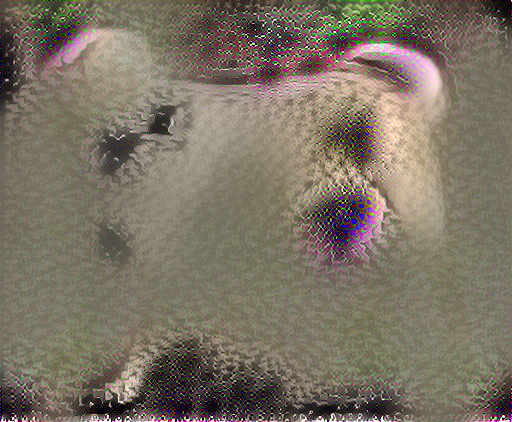

Train step: 300
...............................................

KeyboardInterrupt: ignored

In [ ]:
if __name__ == "__main__":
  util = Utils()
  model = ModelStructure(util)
  model_training_and_output(10,100,model)